1.3 – Comparative Evaluation & Feasibility

Cell 1: Imports & Paths
Cell 2: Load ML scores
Cell 3: Load Regex baseline
Cell 4: Combine & validate schema
Cell 5: Compute MICRO metrics (core table)
Cell 6: Deliverable 1.3.1 – Tables
Cell 7: Deliverable 1.3.1 – Charts
Cell 8: Deliverable 1.3.2 – Feasibility notes (text cell)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Paths 

ML_PATH = Path("exports/scores_per_doc.csv")
RX_PATH = Path("exports/regex_scores_per_doc.csv")

df_ml = pd.read_csv(ML_PATH)
df_rx = pd.read_csv(RX_PATH)

In [3]:
# --- Standardize key column name ---
# If your ML file uses 'filename' you're good. If it uses something else, normalize here.
if "doc_id" in df_ml.columns and "filename" not in df_ml.columns:
    df_ml = df_ml.rename(columns={"doc_id": "filename"})
if "file" in df_ml.columns and "filename" not in df_ml.columns:
    df_ml = df_ml.rename(columns={"file": "filename"})

# --- Keep only the columns needed for aggregation (avoid NaN noise from extra cols) ---
keep_cols = ["filename", "variant", "section", "mode", "tp", "fp", "fn"]
df_ml = df_ml[[c for c in keep_cols if c in df_ml.columns]].copy()
df_rx = df_rx[[c for c in keep_cols if c in df_rx.columns]].copy()

# Ensure numeric counts
for c in ["tp", "fp", "fn"]:
    df_ml[c] = pd.to_numeric(df_ml[c], errors="coerce").fillna(0)
    df_rx[c] = pd.to_numeric(df_rx[c], errors="coerce").fillna(0)

df_all = pd.concat([df_ml, df_rx], ignore_index=True)

# Order variants with baseline first (makes tables/plots easier to read)
order = ["regex_baseline"] + sorted([v for v in df_all["variant"].unique() if v != "regex_baseline"])
df_all["variant"] = pd.Categorical(df_all["variant"], categories=order, ordered=True)

df_all = df_all[
    ~((df_all["variant"] == "regex_baseline") & (df_all["mode"] == "relaxed"))
].copy()

df_all.head()


,filename,variant,section,mode,tp,fp,fn
0,1017655_10K_2020_0001654954-21-003649.json,sm_base,item_7,strict,0.0,0.0,63.0
1,1017655_10K_2020_0001654954-21-003649.json,sm_base,item_7,relaxed,0.0,0.0,63.0
2,1017655_10K_2020_0001654954-21-003649.json,sm_base,item_10,strict,23.0,72.0,39.0
3,1017655_10K_2020_0001654954-21-003649.json,sm_base,item_10,relaxed,30.0,65.0,32.0
4,1017655_10K_2020_0001654954-21-003649.json,sm_aug,item_7,strict,38.0,0.0,25.0


In [4]:
def prf_from_counts(tp, fp, fn):
    tp = float(tp); fp = float(fp); fn = float(fn)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0
    return precision, recall, f1

# 1) Micro by (variant, mode, section)
micro = (
    df_all
    .groupby(["variant", "mode", "section"], as_index=False)[["tp","fp","fn"]]
    .sum()
)

micro[["precision","recall","f1"]] = micro.apply(
    lambda r: pd.Series(prf_from_counts(r.tp, r.fp, r.fn)),
    axis=1
)

# 2) Micro overall per (variant, mode) aggregated across sections
overall = (
    micro
    .groupby(["variant","mode"], as_index=False)[["tp","fp","fn"]]
    .sum()
)

overall["section"] = "overall"

overall[["precision","recall","f1"]] = overall.apply(
    lambda r: pd.Series(prf_from_counts(r.tp, r.fp, r.fn)),
    axis=1
)

micro_all = pd.concat([micro, overall], ignore_index=True)

# Drop impossible rows
micro_all = micro_all[
    ~(
        (micro_all["tp"] == 0) &
        (micro_all["fp"] == 0) &
        (micro_all["fn"] == 0)
    )
]

# Drop regex relaxed rows
micro_all = micro_all[
    ~(
        (micro_all["variant"] == "regex_baseline") &
        (micro_all["mode"] == "relaxed")
    )
]


C:\Users\abrid\AppData\Local\Temp\ipykernel_28200\1238236498.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["variant", "mode", "section"], as_index=False)[["tp","fp","fn"]]
C:\Users\abrid\AppData\Local\Temp\ipykernel_28200\1238236498.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["variant","mode"], as_index=False)[["tp","fp","fn"]]


In [5]:
micro_all_clean = micro_all[micro_all["section"].isin(["item_7", "item_10", "overall"])].copy()

overall_table = micro_all_clean[micro_all_clean["section"] == "overall"].sort_values(["mode", "variant"])
overall_table[["variant","mode","tp","fp","fn","precision","recall","f1"]]

f1_pivot = micro_all_clean.pivot_table(index=["variant","mode"], columns="section", values="f1")
f1_pivot = f1_pivot[["item_10", "item_7", "overall"]]
f1_pivot


C:\Users\abrid\AppData\Local\Temp\ipykernel_28200\959972910.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  f1_pivot = micro_all_clean.pivot_table(index=["variant","mode"], columns="section", values="f1")


section                  item_10    item_7   overall
variant        mode                                 
regex_baseline strict   0.298913  0.128507  0.171079
sm_aug         relaxed  0.465116  0.708758  0.638072
               strict   0.368771  0.404616  0.394217
sm_base        relaxed  0.276035  0.000000  0.126509
               strict   0.218319  0.000000  0.100058
trf_aug        relaxed  0.484321  0.708758  0.645823
               strict   0.390244  0.404616  0.400586
trf_base       relaxed  0.373563  0.000000  0.158730
               strict   0.333333  0.000000  0.141636

F1 Score (Overall Effectiveness)

What F1 measures:
F1 score balances precision (how accurate extractions are) and recall (how much relevant information is captured). It answers the question:

How well does this method perform overall, considering both correctness and coverage?

A high F1 score indicates that a method is both accurate when it extracts entities and effective at finding most of the relevant entities present in the document.

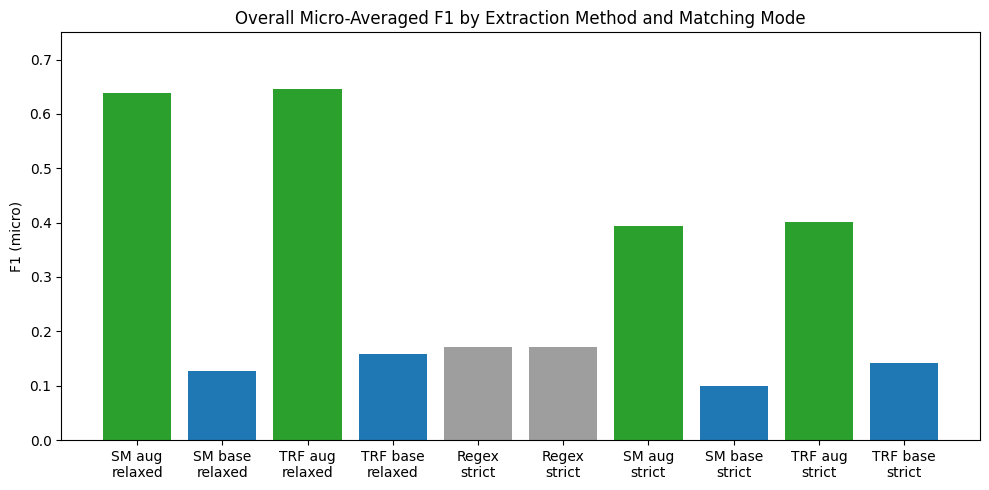

In [6]:
tmp = overall_table.copy()
x = np.arange(len(tmp))

# Short x-axis labels (no collapsing)
def short_variant(v):
    if v == "regex_baseline":
        return "Regex"
    # keep model family info, but shorter
    v = v.replace("sm_", "SM ").replace("trf_", "TRF ")
    v = v.replace("_aug", " Aug").replace("_base", " Base")
    return v

labels = [f"{short_variant(v)}\n{m}" for v, m in zip(tmp["variant"], tmp["mode"])]

# Color by regex/base/aug
def color_for_variant(v):
    if v == "regex_baseline":
        return "#9e9e9e"     # gray
    if v.endswith("_aug"):
        return "#2ca02c"     # green
    if v.endswith("_base"):
        return "#1f77b4"     # blue
    return "#333333"

colors = [color_for_variant(v) for v in tmp["variant"]]

plt.figure(figsize=(10, 5))
plt.bar(x, tmp["f1"], color=colors)
plt.xticks(x, labels, rotation=0)   # keep two-line labels
plt.ylabel("F1 (micro)")
plt.title("Overall Micro-Averaged F1 by Extraction Method and Matching Mode")
plt.ylim(0, 0.75)
plt.tight_layout()
plt.show()


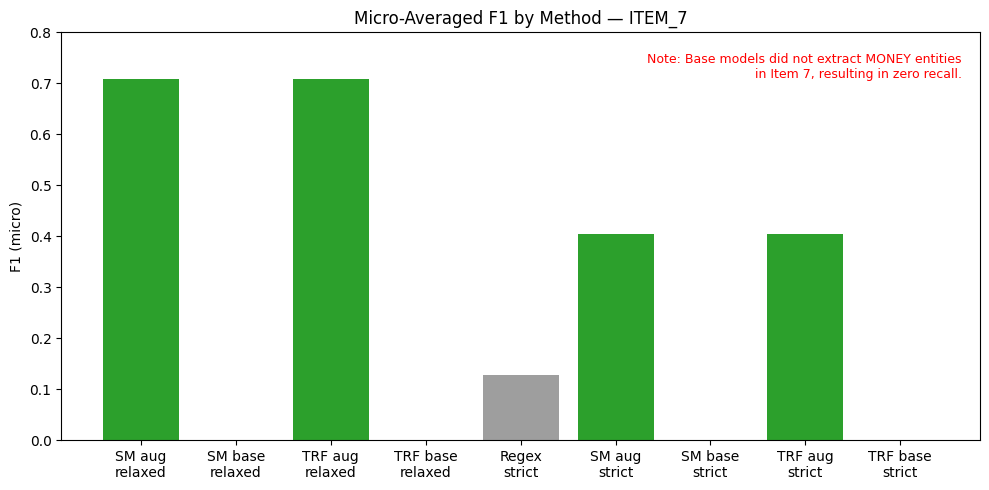

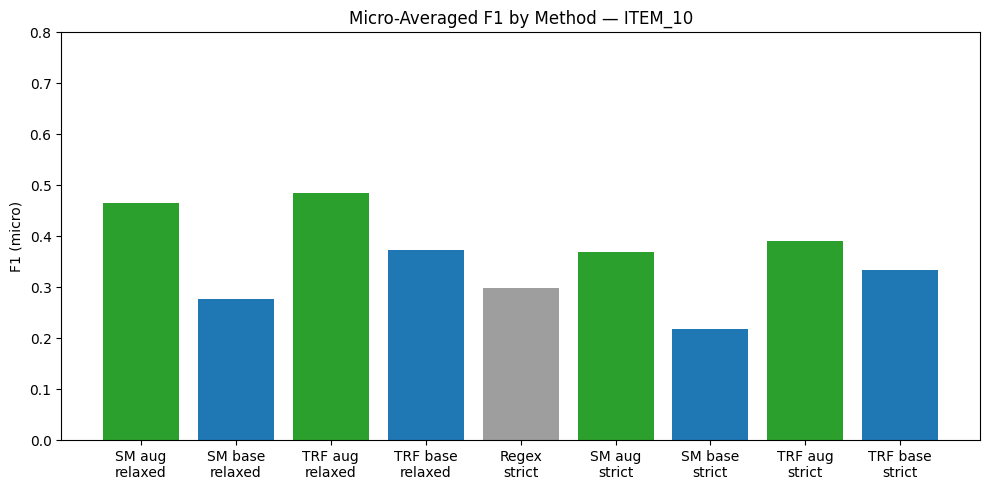

In [14]:
for section in ["item_7", "item_10"]:
    t = micro_all[micro_all["section"] == section].sort_values(["mode","variant"])
    if t.empty:
        continue

    x = np.arange(len(t))

    # --- short x-axis labels (same style as overall chart) ---
    def short_variant(v):
        if v == "regex_baseline":
            return "Regex"
        v = v.replace("sm_", "SM ").replace("trf_", "TRF ")
        v = v.replace("_aug", " aug").replace("_base", " base")
        return v

    labels = [f"{short_variant(v)}\n{m}" for v, m in zip(t["variant"], t["mode"])]

    # --- color by regex/base/aug ---
    def color_for_variant(v):
        if v == "regex_baseline":
            return "#9e9e9e"     # gray
        if v.endswith("_aug"):
            return "#2ca02c"     # green
        if v.endswith("_base"):
            return "#1f77b4"     # blue
        return "#333333"

    colors = [color_for_variant(v) for v in t["variant"]]

    # --- plot ---
    plt.figure(figsize=(10, 5))
    plt.bar(x, t["f1"], color=colors)

    plt.xticks(x, labels)
    plt.ylabel("F1 (micro)")
    plt.title(f"Micro-Averaged F1 by Method — {section.upper()}")
    if section == "item_7":
        plt.annotate(
            "Note: Base models did not extract MONEY entities\nin Item 7, resulting in zero recall.",
            xy=(0.98, 0.95),
            xycoords="axes fraction",
            ha="right",
            va="top",
            fontsize=9,
            color="red"
    )


    plt.ylim(0, 0.8)  # keeps scale consistent across the two charts
    plt.tight_layout()
    plt.show()



Base (non-augmented) models failed to extract Item 7 MONEY entities because the training data did not sufficiently represent the diverse, narrative financial expressions present in MD&A sections. This behavior underscores that model performance in financial narratives is driven more by training data coverage than model architecture, reinforcing the need for targeted augmentation and analyst oversight.

Overall Precision (Accuracy proxy)

Answers: “When the model extracts something, how often is it correct?”

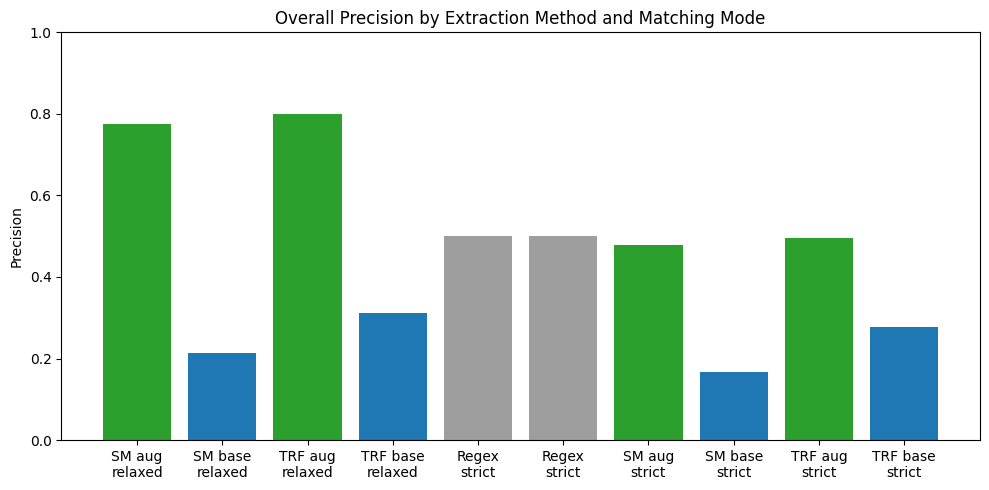

In [15]:
tmp = overall_table.copy()
x = np.arange(len(tmp))

# Short labels (same as before)
def short_variant(v):
    if v == "regex_baseline":
        return "Regex"
    v = v.replace("sm_", "SM ").replace("trf_", "TRF ")
    v = v.replace("_aug", " aug").replace("_base", " base")
    return v

labels = [f"{short_variant(v)}\n{m}" for v, m in zip(tmp["variant"], tmp["mode"])]

# Colors by model type
def color_for_variant(v):
    if v == "regex_baseline":
        return "#9e9e9e"     # gray
    if v.endswith("_aug"):
        return "#2ca02c"     # green
    if v.endswith("_base"):
        return "#1f77b4"     # blue
    return "#333333"

colors = [color_for_variant(v) for v in tmp["variant"]]

plt.figure(figsize=(10, 5))
plt.bar(x, tmp["precision"], color=colors)
plt.xticks(x, labels)
plt.ylabel("Precision")
plt.title("Overall Precision by Extraction Method and Matching Mode")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


Overall Recall

Answers: “How much of the relevant information does the model find?”

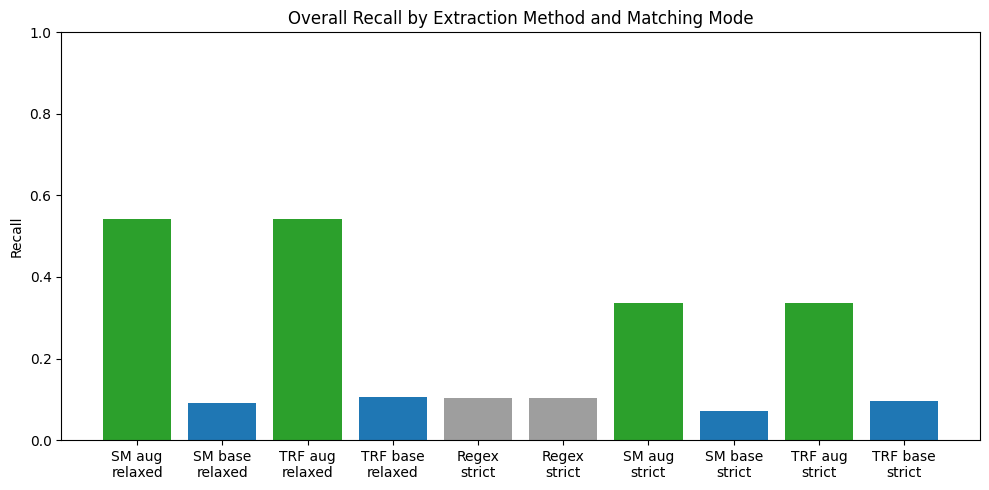

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(x, tmp["recall"], color=colors)
plt.xticks(x, labels)
plt.ylabel("Recall")
plt.title("Overall Recall by Extraction Method and Matching Mode")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()
